<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Statistics (b)

## Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

### Introductory Example

In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1)

In [5]:
reg

array([2.03384161, 3.77649234])

Text(0, 0.5, 'y')

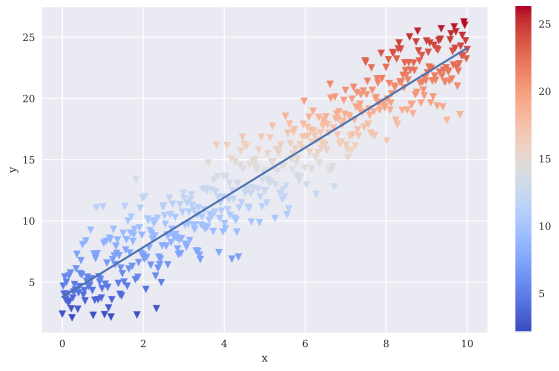

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('../../images/ch13/stat_15.png');

In [7]:
import warnings; warnings.simplefilter('ignore')

To install `pymc3` on Mac, use:

    conda install -c conda-forge mkl pymc3 theano-pymc

In [8]:
import pymc3 as pm

In [9]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)  
    beta = pm.Normal('beta', mu=0, sd=10)  
    sigma = pm.Uniform('sigma', lower=0, upper=10)  
    y_est = alpha + beta * x  
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
                           observed=y)  
    
    # inference
    start = pm.find_MAP()  
    step = pm.NUTS()  
    trace = pm.sample(100, tune=1000, start=start,
                      progressbar=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.


CPU times: user 5.82 s, sys: 338 ms, total: 6.16 s
Wall time: 9.66 s


In [10]:
pm.summary(trace)  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.804,0.159,3.522,4.120,0.021,0.015,65.0,78.0,1.03
beta,2.028,0.028,1.981,2.082,0.003,0.002,91.0,122.0,1.01
sigma,2.012,0.058,1.915,2.117,0.005,0.003,142.0,185.0,1.01


In [11]:
trace[0]  

{'alpha': 3.6424062568869697,
 'beta': 2.050404326325664,
 'sigma_interval__': -1.460617179026415,
 'sigma': 1.883729474401441}

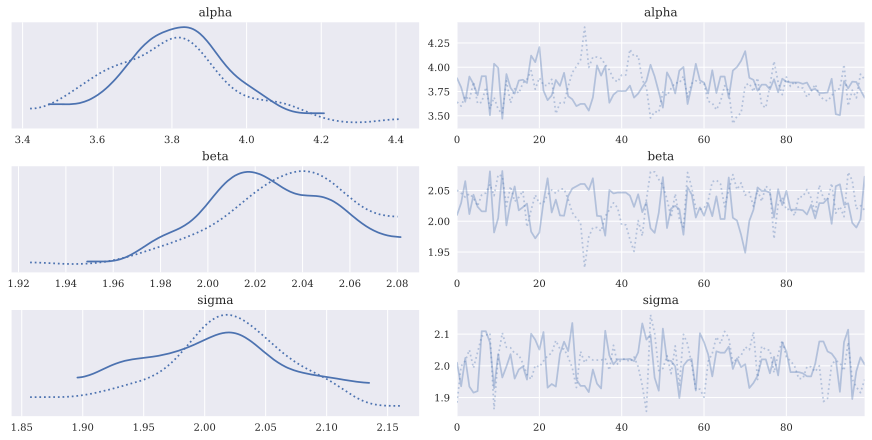

In [12]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});  
# plt.savefig('../../images/ch13/stat_16.png');

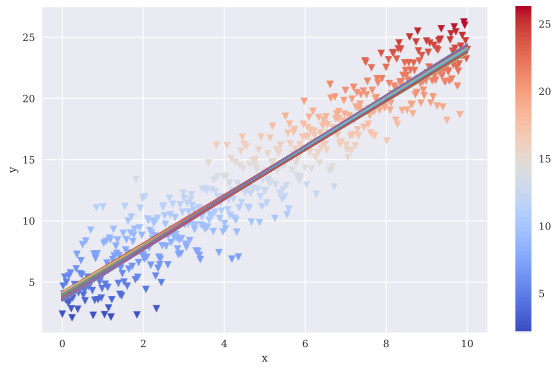

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x);
# plt.savefig('../../images/ch13/stat_17.png');

### Two Financial Instruments

In [14]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [15]:
data = raw[['GDX', 'GLD']].dropna()

In [16]:
data = data / data.iloc[0]  

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDX     2138 non-null   float64
 1   GLD     2138 non-null   float64
dtypes: float64(2)
memory usage: 50.1 KB


In [18]:
data.iloc[-1] / data.iloc[0] - 1  

GDX   -0.532383
GLD    0.080601
dtype: float64

In [19]:
data.corr()  

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


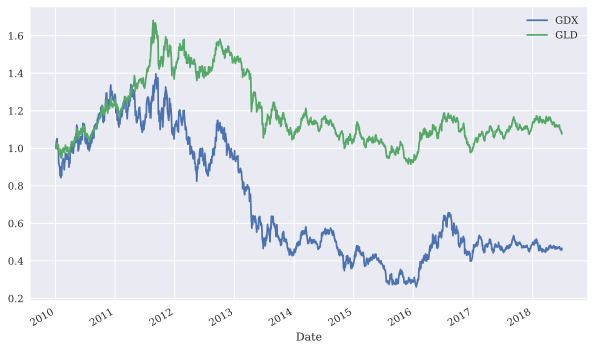

In [20]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch13/stat_18.png');

In [21]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [22]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  
mpl_dates[:3]

array([14613., 14614., 14615.])

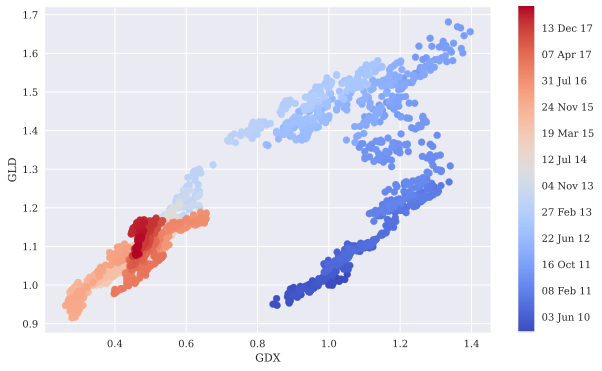

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));  
# plt.savefig('../../images/ch13/stat_19.png');

In [24]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    y_est = alpha + beta * data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma,
                           observed=data['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(250, tune=2000, start=start,
                      progressbar=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 2_000 tune and 250 draw iterations (4_000 + 500 draws total) took 4 seconds.


In [25]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.914,0.006,0.903,0.925,0.000,0.0,209.0,139.0,1.02
beta,0.385,0.008,0.371,0.400,0.001,0.0,244.0,137.0,1.03
sigma,0.119,0.002,0.116,0.123,0.000,0.0,361.0,281.0,1.00


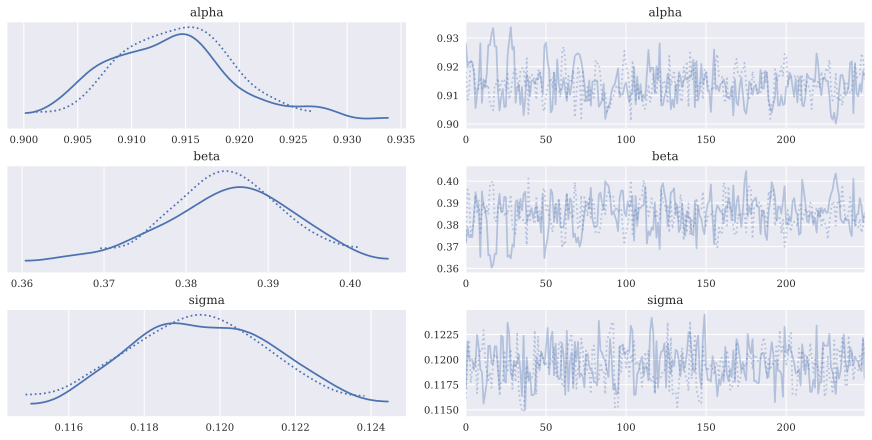

In [26]:
fig = pm.traceplot(trace)
# plt.savefig('../../images/ch13/stat_20.png');

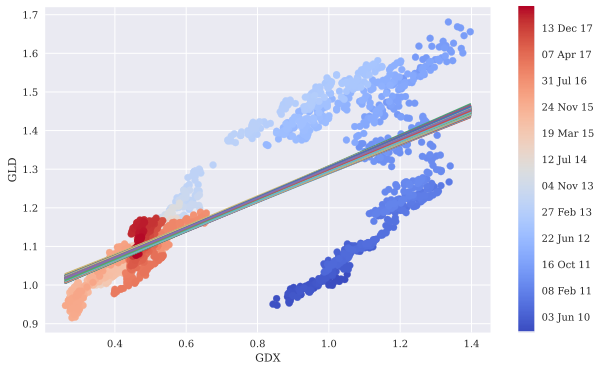

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));
# plt.savefig('../../images/ch13/stat_21.png');

In [28]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [29]:
subsample_alpha = 50
subsample_beta = 50

In [30]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval=.1)  
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval=.1)  
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
                        shape=int(len(data) / subsample_alpha))  
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
                        shape=int(len(data) / subsample_beta))  
    alpha_r = np.repeat(alpha, subsample_alpha)  
    beta_r = np.repeat(beta, subsample_beta)  
    regression = alpha_r + beta_r * data['GDX'].values[:2100]  
    sd = pm.Uniform('sd', 0, 20)  
    likelihood = pm.Normal('GLD', mu=regression, sd=sd,
                           observed=data['GLD'].values[:2100])  

In [31]:
%%time
import scipy.optimize as sco
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta],
                        method='L-BFGS-B')
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(250, tune=1000, start=start,
                         progressbar=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]


Sampling 2 chains for 1_000 tune and 250 draw iterations (2_000 + 500 draws total) took 71 seconds.


CPU times: user 22.3 s, sys: 810 ms, total: 23.1 s
Wall time: 1min 34s


In [32]:
pm.summary(trace_rw).head()  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.670,0.041,0.583,0.738,0.001,0.001,1023.0,269.0,1.01
alpha[1],0.424,0.041,0.354,0.502,0.001,0.001,1264.0,348.0,1.00
alpha[2],0.458,0.065,0.351,0.588,0.002,0.001,1349.0,427.0,1.00
alpha[3],0.271,0.045,0.189,0.356,0.001,0.001,1041.0,336.0,1.00
alpha[4],0.649,0.057,0.546,0.756,0.002,0.001,1308.0,293.0,1.01


In [33]:
sh = np.shape(trace_rw['alpha'])  
sh  

(500, 42)

In [34]:
part_dates = np.linspace(min(mpl_dates),
                         max(mpl_dates), sh[1])  

In [35]:
index = [dt.datetime.fromordinal(int(date)) for
        date in part_dates]  

In [36]:
alpha = {'alpha_%i' % i: v for i, v in
         enumerate(trace_rw['alpha']) if i < 20}  

In [37]:
beta = {'beta_%i' % i: v for i, v in
         enumerate(trace_rw['beta']) if i < 20}  

In [38]:
df_alpha = pd.DataFrame(alpha, index=index)  

In [39]:
df_beta = pd.DataFrame(beta, index=index)  

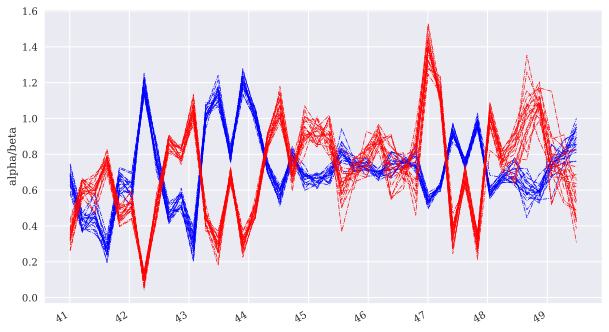

In [40]:
ax = df_alpha.plot(color='b', style='-.', legend=False,
                   lw=0.7, figsize=(10, 6))
df_beta.plot(color='r', style='-.', legend=False,
             lw=0.7, ax=ax)
plt.ylabel('alpha/beta');
# plt.savefig('../../images/ch13/stat_22.png');

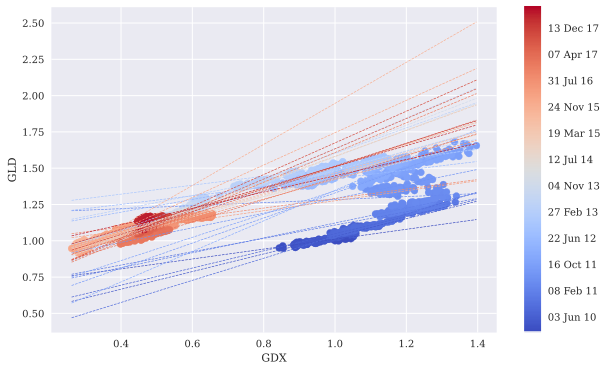

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(sh[1]):  
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, '--', lw=0.7,
            color=plt.cm.coolwarm(i / sh[1]))
# plt.savefig('../../images/ch13/stat_23.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>